#  <span style="color:beige">Del 2 - Analys av diamantdata – Data Story </span>

I denna analys undersöker vi ett dataset innehållande över 50 000 diamanter.  
Syftet är att analysera mönster och insikter kopplat till pris, storlek, färg, klarhet och slipning.

Vi arbetar för ett företag som överväger att investera i diamanter. Denna analys hjälper till att förstå marknaden bättre och ge rekommendationer för framtida beslut.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
df = pd.read_csv('diamonds/diamonds.csv')

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [51]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## <span style="color:turquoise"> Datakvalitet – Städning av datasetet </span>

Innan vi påbörjar analysen kontrollerar vi datakvaliteten.  
Eftersom fysiska diamanter inte kan ha 0 i längd, bredd eller djup undersöker vi om det finns ogiltiga värden i variablerna `x`, `y` och `z`.

Vi filtrerar bort alla rader där någon av dessa dimensioner är noll.

In [52]:
# Visar hur många rader det finns som har ogiltiga mått (existerar helt enkelt inte)
invalid_rows  = df[(df['x'] == 0) | (df['y'] == 0) | (df['z'] == 0)]
print(f"Antal ogiltiga rader (x, y eller z = 0): {len(invalid_rows)}")

# Tvätta datan. Behåller bara raderna med giltiga mått.
df_clean = df[(df['x'] > 0) & (df['y'] > 0) & (df['z'] > 0)].copy()

print(f"Antar rader före städning: {len(df)}")
print(f"Antal rader efter städning: {len(df_clean)}")

Antal ogiltiga rader (x, y eller z = 0): 20
Antar rader före städning: 53940
Antal rader efter städning: 53920


In [53]:
# Nu har vi tvättat bort de rader som har ogiltiga mått. Vi kan nu kolla på datan för att se om det har fungerat.

df_clean.info()

df_clean.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 53920 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53920 non-null  float64
 1   cut      53920 non-null  object 
 2   color    53920 non-null  object 
 3   clarity  53920 non-null  object 
 4   depth    53920 non-null  float64
 5   table    53920 non-null  float64
 6   price    53920 non-null  int64  
 7   x        53920 non-null  float64
 8   y        53920 non-null  float64
 9   z        53920 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Nu kan vi se att raden ***"min"*** som tidgare hade 0-värde har blivit tvättad och har nu korrekt data.

### `Prisfördelning`

Histogrammet nedan visar hur priserna är fördelade bland alla diamanter.  
Vi kan se att majoriteten av diamanterna har ett relativt lågt pris, medan ett fåtal är väldigt dyra.

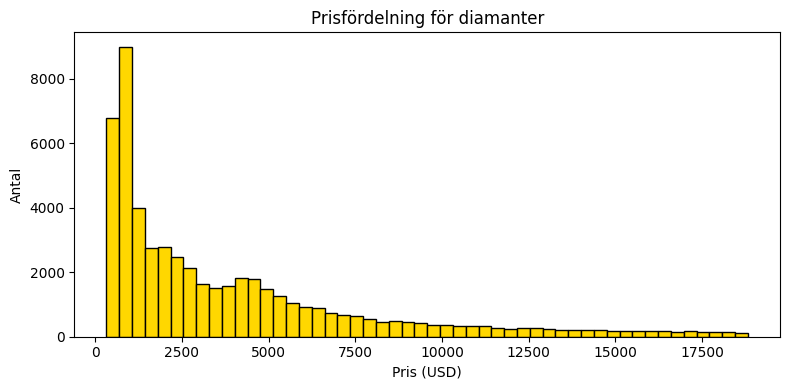

In [54]:
plt.figure(figsize=(8, 4))
plt.hist(df_clean['price'], bins=50, color='gold', edgecolor='black')
plt.title('Prisfördelning för diamanter')
plt.xlabel('Pris (USD)')
plt.ylabel('Antal')
plt.tight_layout()
plt.show()

### `Pris beroende på klarhet`

Här ser vi hur medelpriset varierar beroende på diamantens klarhetsgrad.  
Diamanter med bättre klarhet (som IF, VVS1) tenderar att ha ett högre pris.

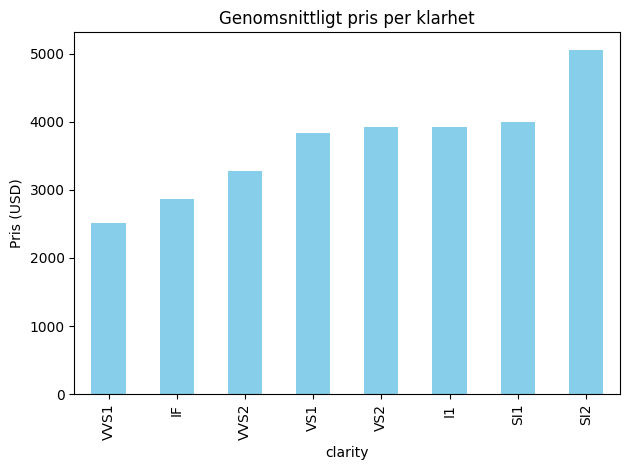

In [55]:
df_clean.groupby('clarity')['price'].mean().sort_values().plot(kind='bar', color='skyblue')
plt.title('Genomsnittligt pris per klarhet')
plt.ylabel('Pris (USD)')
plt.tight_layout()
plt.show()

### `Pris beroende på carat (vikt)`

Priset ökar tydligt med carat. Denna plot visar att större stenar har ett betydligt högre genomsnittspris.  
Det är därför viktigt att väga in storlek vid investeringsbeslut.

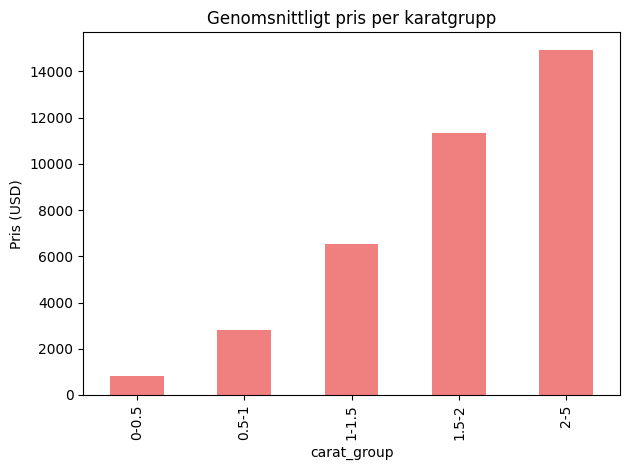

In [56]:
df_clean['carat_group'] = pd.cut(df_clean['carat'], bins=[0, 0.5, 1, 1.5, 2, 5], labels=['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-5'])
df_clean.groupby('carat_group', observed=True)['price'].mean().plot(kind='bar', color='lightcoral')
plt.title('Genomsnittligt pris per karatgrupp')
plt.ylabel('Pris (USD)')
plt.tight_layout()
plt.show()

### `Pris beroende på färg`

Denna barplot visar hur medelpriset skiljer sig mellan olika färggrader (D till J).  
Skillnaderna är mindre dramatiska än för carat och klarhet, men ändå märkbara.

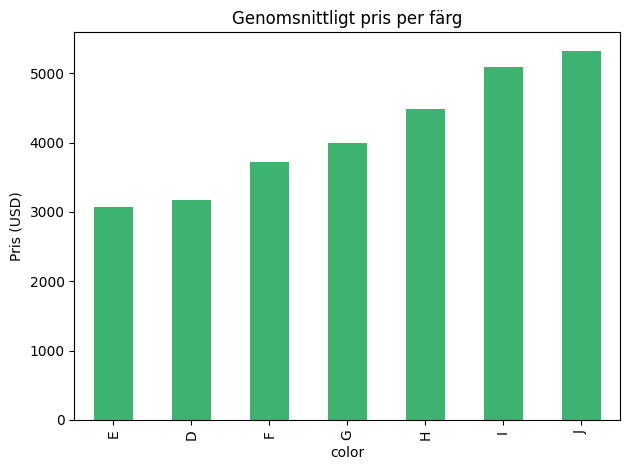

In [57]:
df_clean.groupby('color')['price'].mean().sort_values().plot(kind='bar', color='mediumseagreen')
plt.title('Genomsnittligt pris per färg')
plt.ylabel('Pris (USD)')
plt.tight_layout()
plt.show()

### `Samband mellan carat och pris`

Här syns ett tydligt positivt samband: ju större diamanten är (i carat), desto högre pris.  
Dock ser vi också att det finns variation, inte alla stora diamanter är extremt dyra. Detta tyder på att även andra faktorer spelar in.

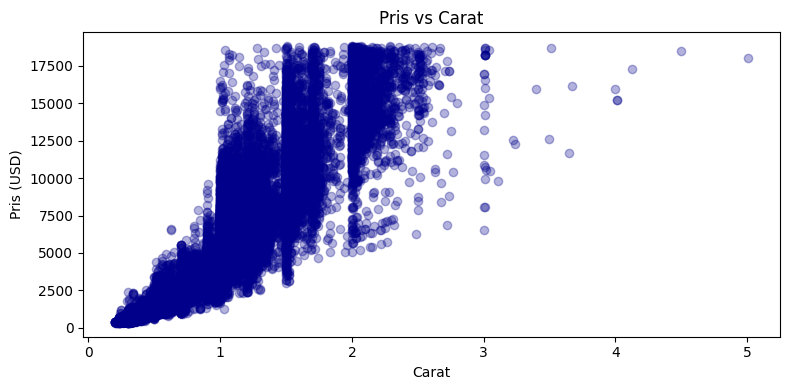

In [58]:
plt.figure(figsize=(8, 4))
plt.scatter(df_clean['carat'], df_clean['price'], alpha=0.3, color='darkblue')
plt.title('Pris vs Carat')
plt.xlabel('Carat')
plt.ylabel('Pris (USD)')
plt.tight_layout()
plt.show()

## <span style="color:turquoise"> Lärdomar & insikter </span>

- Det finns ett starkt samband mellan karat och pris. Större diamanter är betydligt dyrare.
- Klarhet och färg påverkar också pris, men inte lika mycket som carat.
- Cut påverkar hur attraktiv stenen är, men påverkar inte priset lika starkt som förväntat.

## <span style="color:turquoise"> Executive Summary </span>

- Pris påverkas mest av carat, följt av klarhet och färg.
- För att Guldfynd ska ge sig in på diamantmarknaden bör man överväga att fokusera på stenar med:
  - Hög carat (≥1.5), då dessa ger störst avkastning.
  - Klarhet VS1 eller bättre.
- Slipning är viktigt för utseende men mindre kritiskt för prisbilden.

Analysen ger ett bra underlag för vidare investeringsbeslut.